# INSTALL REQUIRED LIBRARIES

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install git+https://github.com/openai/CLIP.git
!pip install cma pillow matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 87.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.9 MB/s eta 0:00:000

# SETUP

## IMPORT LIBRARIES

In [2]:
import numpy as np
import pandas as pd 
import torch
import clip
from PIL import Image
import numpy as np
import cma
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## LOAD CLIP MODEL

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 85.0MiB/s]


## LOAD IMAGE AND TEXT

In [4]:
def load_image_text():
    """
    INPUT (via CLI):
    - Image path
    - Text query
    Pre-process the given image
    - Open image
    - Get the image dimensions
    Pre-process the given text query
    - Tokenize it using CLIP's tokenizer
    - Creating the normalized embedding using CLIP's encoder
    RETURNS :
    - Image 
    - Text query 
    - Text embedding 
    - Image dimensions
    """
    image_path = input("Enter image path\n")
    image = Image.open(image_path).convert("RGB")
    text_query = input("Enter text query\n")

    text_tokens = clip.tokenize([text_query]).to(device)
    with torch.no_grad():
        text_embedding = model.encode_text(text_tokens)
        text_embedding /= text_embedding.norm(dim=-1, keepdim=True)

    img_w, img_h = image.size
    return image, text_query, text_embedding, img_w, img_h

## SET PARAMETERS

In [19]:
N_FRAMES = 5 # Number of frames initialized
AREA_PENALTY_FACTOR = 0.05 # To prevent large boxes
OVERLAP_PENALTY_FACTOR = 0.2 # To motivate different frames to explore different paths
SIGMA = 0.08

# FUNCTION DEFINITIONS

## HELPER FUNCTIONS

In [20]:
def crop_and_embed(box):
    """
    INPUT:
    - Dimension of frame
    Pre-process the image cropped in given frame for CLIP
    Create image embeddings
    RETURNS:
    - Image embedding
    """
    x_c, y_c, w, h = box
    x0 = int(np.clip(x_c - w/2, 0, 1) * img_w)
    y0 = int(np.clip(y_c - h/2, 0, 1) * img_h)
    x1 = int(np.clip(x_c + w/2, 0, 1) * img_w)
    y1 = int(np.clip(y_c + h/2, 0, 1) * img_h)
    if x1 <= x0 or y1 <= y0:
        return None
    crop = image.crop((x0, y0, x1, y1))
    crop_tensor = preprocess(crop).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.encode_image(crop_tensor)
        emb /= emb.norm(dim=-1, keepdim=True)
    return emb

def intersection_area(box1, box2):
    """
    INPUT:
    - Dimensions of two frames/boxes
    Check how much area is overlapping between two frames
    RETURNS:
    - Overlap area
    """
    x01 = box1[0] - box1[2]/2
    y01 = box1[1] - box1[3]/2
    x11 = box1[0] + box1[2]/2
    y11 = box1[1] + box1[3]/2

    x02 = box2[0] - box2[2]/2
    y02 = box2[1] - box2[3]/2
    x12 = box2[0] + box2[2]/2
    y12 = box2[1] + box2[3]/2

    x_overlap = max(0, min(x11, x12) - max(x01, x02))
    y_overlap = max(0, min(y11, y12) - max(y01, y02))
    return x_overlap * y_overlap

## FITNESS FUNCTION

In [21]:
def fitness(flat_params, text_embedding):
    """
    INPUT:
    - Flat image params
    - Query text embeddings
    Calculates the cosine similarity score between the frame embeddings
    and text embeddings
    Calculates score for optimization which includes similarity score,
    area penalty and overlap penalty
    RETURNS:
    - -ve (Similarity score - Area penalty - Overlap penalty)
    """
    flat_params = np.clip(flat_params, 0, 1)
    score = 0
    boxes = []

    for i in range(N_FRAMES):
        box = flat_params[i*4:(i+1)*4]
        boxes.append(box)
        emb = crop_and_embed(box)
        sim = (emb @ text_embedding.T).item() if emb is not None else 0
        area_penalty = AREA_PENALTY_FACTOR * (box[2]*box[3])
        score += sim - area_penalty

    overlap_penalty = 0
    for i in range(N_FRAMES):
        for j in range(i+1, N_FRAMES):
            overlap_penalty += intersection_area(boxes[i], boxes[j])
    overlap_penalty *= OVERLAP_PENALTY_FACTOR

    return -(score - overlap_penalty)

def init(text_embedding,scales = [0.2, 0.35, 0.5, 0.6, 0.8],positions = [(0.25,0.25),(0.5,0.5),(0.75,0.75),(0.25,0.75),(0.75,0.25)], sigma = SIGMA
        ,maxiter = 200):
    """
    INPUT:
    - Text embedding
    - Scales of initial frames (1 for initial shapes to be square)
    - Positions of initial frames
    - Hyper parameter sigma
    - Max number of iterations
    Run the optimization algorithm
    Calculates the best scores for each frame
    RETURNS:
    - Best frame params for all initialized frames
    """
    initial_params = []
    for i in range(N_FRAMES):
        x_c, y_c = positions[i % len(positions)]
        w = h = scales[i % len(scales)]
        initial_params.extend([x_c, y_c, w, h])

    x0 = np.array(initial_params)
    es = cma.CMAEvolutionStrategy(x0, sigma, {'maxiter': maxiter})

    while not es.stop():
        solutions = es.ask()
        fitnesses = [fitness(s, text_embedding) for s in solutions]
        es.tell(solutions, fitnesses)
        es.disp()
    best_params = np.clip(es.result.xbest, 0, 1)
    return best_params

def Visualize(best_params, image, text_query):
    """
    INPUTS:
    - Best frame after optimization
    - Input image
    - Text Query
    Selects the top frame out of all initialized
    OUTPUT:
     - Shows image + bounding box
    """
    best_sim = -float('inf')
    best_box = None
    for i in range(N_FRAMES):
        box = best_params[i*4:(i+1)*4]
        emb = crop_and_embed(box)
        if emb is None:
            continue
        sim = (emb @ text_embedding.T).item()
        if sim > best_sim:
            best_sim = sim
            best_box = box
    
    x_c, y_c, w, h = best_box
    x0 = int(np.clip(x_c - w/2, 0, 1) * img_w)
    y0 = int(np.clip(y_c - h/2, 0, 1) * img_h)
    x1 = int(np.clip(x_c + w/2, 0, 1) * img_w)
    y1 = int(np.clip(y_c + h/2, 0, 1) * img_h)
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.title(text_query)
    plt.show()


# CODE EXECUTION:

Enter image path
 /kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images/test2014/COCO_test2014_000000000403.jpg
Enter text query
 woman clapping


(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 20 (seed=338071, Fri Aug 15 08:21:21 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 -1.117207769080449e+00 1.0e+00 7.61e-02  7e-02  8e-02 0:00.6
    2     24 -1.097633200432994e+00 1.1e+00 7.29e-02  7e-02  7e-02 0:01.2
    3     36 -1.116705139200613e+00 1.1e+00 7.19e-02  7e-02  7e-02 0:01.7
    9    108 -1.222371559918863e+00 1.3e+00 7.08e-02  7e-02  7e-02 0:05.2
   16    192 -1.199929399501553e+00 1.6e+00 7.12e-02  7e-02  8e-02 0:09.2
   25    300 -1.230041851843791e+00 1.8e+00 6.63e-02  6e-02  8e-02 0:14.4
   36    432 -1.276690611580794e+00 2.0e+00 5.08e-02  4e-02  6e-02 0:20.6
   49    588 -1.247402153849155e+00 2.3e+00 4.32e-02  4e-02  5e-02 0:27.9
   64    768 -1.257173187411426e+00 2.7e+00 3.93e-02  3e-02  5e-02 0:36.1
   81    972 -1.284156995771697e+00 2.9e+00 2.80e-02  2e-02  4e-02 0:45.4
   99   1188 -1.283416525604639e+00 3.2e+00 1.71e-02  1e-02  2e-02 0:55.5
  100   1200 -1.284970

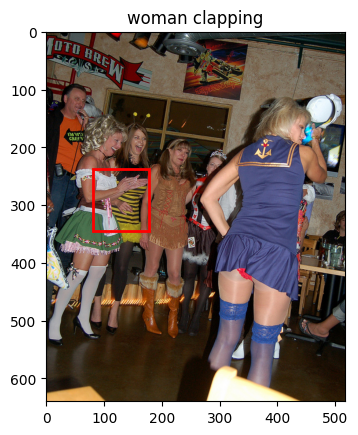

In [22]:
if __name__ == "__main__":
    image, text_query, text_embedding, img_w, img_h = load_image_text()
    best_params = init(text_embedding)
    Visualize(best_params, image, text_query)